In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from azureml.core import Workspace
ws = Workspace.from_config()

print(ws.name, ws.location, ws.resource_group, sep='\n')

EkagraGupta
germanywestcentral
Personal


In [4]:
experiment_name = "pytorch-torchvision-cifar"

from azureml.core import Experiment
experiment = Experiment(
    workspace=ws,
    name=experiment_name
)

In [6]:
from azureml.core.compute import AmlCompute
import os

compute_name = os.environ.get('AML_COMPUTE_CLUSTER_NAME', 'cpu-cluster')

compute_target = ws.compute_targets[compute_name]
if compute_target and type(compute_target) is AmlCompute:
    print(f"Found compute target: {compute_name}")

Found compute target: cpu-cluster


In [7]:
from azureml.core import Dataset

data_folder = os.path.join(os.getcwd(), "cifar_data")
os.makedirs(data_folder, exist_ok=True)

from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = datasets.CIFAR10(
    data_folder,
    download=True,
    train=True,
    transform=transform
)
testset = datasets.CIFAR10(
    data_folder,
    download=True,
    train=False,
    transform=transform
)

datastore = ws.get_default_datastore()
datastore.upload(
    src_dir=data_folder,
    target_path="torchvision-cifar-dataset",
    overwrite=True
)

dataset = Dataset.File.from_files(
    path=(
        datastore,
        "torchvision-cifar-dataset/"
    )
)
registered_dataset = dataset.register(
    workspace=ws,
    name="torchvision-cifar-dataset",
    description="CIFAR10 dataset from torchvision for training"
)
print(f"Dataset registered: {registered_dataset.name}")

100%|██████████| 170498071/170498071 [00:18<00:00, 9470280.02it/s] 


Extracting /home/ekagra/Documents/GitHub/cifar10_azureml/cifar_data/cifar-10-python.tar.gz to /home/ekagra/Documents/GitHub/cifar10_azureml/cifar_data
Files already downloaded and verified


"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 9 files
Uploading /home/ekagra/Documents/GitHub/cifar10_azureml/cifar_data/cifar-10-batches-py/batches.meta
Uploaded /home/ekagra/Documents/GitHub/cifar10_azureml/cifar_data/cifar-10-batches-py/batches.meta, 1 files out of an estimated total of 9
Uploading /home/ekagra/Documents/GitHub/cifar10_azureml/cifar_data/cifar-10-batches-py/readme.html
Uploaded /home/ekagra/Documents/GitHub/cifar10_azureml/cifar_data/cifar-10-batches-py/readme.html, 2 files out of an estimated total of 9
Uploading /home/ekagra/Documents/GitHub/cifar10_azureml/cifar_data/cifar-10-python.tar.gz
Uploaded /home/ekagra/Documents/GitHub/cifar10_azureml/cifar_data/cifar-10-python.tar.gz, 3 files out of an estimated total of 9
Uploading /home/ekagra/Documents/GitHub/cifar10_azureml/cifar_data/cifar-10-batches-py/data_batch_2
Uploaded /home/ekagra/Documents/GitHub/cifar10_azureml/cifar_data/cifar-10-batches-py/data_batch_2, 4 files out of an estimated total of 9
Uploading /home/ekagra/Documents

/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ekagra/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDepreca

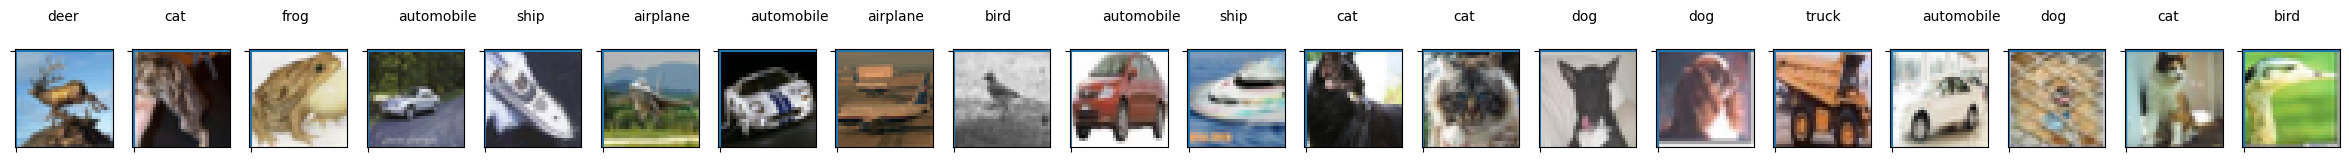

In [15]:
# Load the data
xtrain = trainset.data / 255.0
ytrain = trainset.targets

count = 0
sample_size = 20
plt.figure(figsize=(30, 15))
for i in np.random.permutation(xtrain.shape[0])[:sample_size]:
    count += 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(
        x=10,
        y=-10,
        s=trainset.classes[ytrain[i]],
        fontsize=10
    )
    plt.imshow(xtrain[i].reshape(32, 32, 3))
plt.show()

In [16]:
script_folder = os.path.join(os.getcwd(), experiment_name)
os.makedirs(script_folder, exist_ok=True)

In [17]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

env = Environment("cifar-torchvision-env")
cd = CondaDependencies.create(
    pip_packages=[
        'azureml-dataset-runtime[pandas,fuse]',  # Required for Azure ML datasets
        'azureml-defaults',                      # Required for Azure ML
        'torch==2.1.1',                          # Match local PyTorch version
        'torchvision==0.16.1',                   # Optional: If you're using torchvision
        'scikit-learn==1.5.1',                   # scikit-learn (for utilities like accuracy_score)
        'numpy==1.23.5',                         # NumPy
        'joblib==1.3.2',                         # joblib (for saving/loading models if needed)
    ],
    conda_packages=[
        'python==3.11.4',                        # Specify Python version
        'numpy==1.23.5'                          # NumPy (also available via Conda for better compatibility)
    ]
)

env.python.conda_dependencies = cd
env.register(workspace=ws)

{
    "assetId": "azureml://locations/germanywestcentral/workspaces/c36fd42d-501f-4209-bad2-0f8e70ac0288/environments/cifar-torchvision-env/versions/1",
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:20241202.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "buildContext": null,
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "cifa

In [38]:
from azureml.core import ScriptRunConfig

args = [
    "--data-folder", registered_dataset.as_mount(),
    "--epochs", 5
]
src = ScriptRunConfig(
    source_directory=script_folder,
    script="train.py",
    arguments=args,
    compute_target=compute_target,
    environment=env
)

In [39]:
run = experiment.submit(config=src)
run

run.wait_for_completion(show_output=True)

RunId: pytorch-torchvision-cifar_1738664541_aacc5c14
Web View: https://ml.azure.com/runs/pytorch-torchvision-cifar_1738664541_aacc5c14?wsid=/subscriptions/d96970c2-70d9-48fa-90ee-3efcb3a54b9a/resourcegroups/Personal/workspaces/EkagraGupta&tid=1c2c8b04-2ccf-429d-87a2-2a23ac882b5e

Streaming user_logs/std_log.txt

Data folder: /mnt/azureml/cr/j/e8640b312a4b4ad8a76aa3ee023c030a/cap/data-capability/wd/INPUT_input__e5710804

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, Loss: 1.5364590533716884
Epoch 2/5, Loss: 1.1974385098366975
Epoch 3/5, Loss: 1.0534018784875907
Epoch 4/5, Loss: 0.9453260030850253
Epoch 5/5, Loss: 0.8652110811842846
Accuracy is: 0.6676682692307693
Cleaning up all outstanding Run operations, waiting 300.0 seconds
1 items cleaning up...
Cleanup took 5.367305755615234 seconds

Execution Summary
RunId: pytorch-torchvision-cifar_1738664541_aacc5c14
Web View: https://ml.azure.com/runs/pytorch-torchvision-cifar_1738664541_aacc5c14?wsid=/

{'runId': 'pytorch-torchvision-cifar_1738664541_aacc5c14',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2025-02-04T10:22:54.06718Z',
 'endTimeUtc': '2025-02-04T10:25:54.437591Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlctrain',
  '_azureml.ClusterName': 'cpu-cluster',
  'ContentSnapshotId': 'ad5d0d1a-c4ad-4ec0-9481-301f1cac66aa',
  'azureml.git.repository_uri': 'https://github.com/EkagraGupta/AzureML-using-PyTorch.git',
  'mlflow.source.git.repoURL': 'https://github.com/EkagraGupta/AzureML-using-PyTorch.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': 'ed86a39aefcea2805e756856f0aef40dc56d59ba',
  'mlflow.source.git.commit': 'ed86a39aefcea2805e756856f0aef40dc56d59ba',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'e5710804-3369-4ae2-bea3-054a4e20e64f'}

In [40]:
print(run.get_metrics())
print(run.get_file_names())

{'epochs': 5, 'accuracy': 0.6676682692307693}
['outputs/pytorch-torchvision-cifar-model.pth', 'system_logs/cs_capability/cs-capability.log', 'system_logs/data_capability/data-capability.log', 'system_logs/data_capability/rslex.log.2025-02-04-10', 'system_logs/hosttools_capability/hosttools-capability.log', 'system_logs/lifecycler/execution-wrapper.log', 'system_logs/lifecycler/lifecycler.log', 'system_logs/metrics_capability/metrics-capability.log', 'system_logs/snapshot_capability/snapshot-capability.log', 'user_logs/std_log.txt']


In [41]:
model = run.register_model(
    model_name="pytorch-torchvision-cifar",
    model_path="outputs/pytorch-torchvision-cifar-model.pth"
)
print(model.name, model.id, model.version, sep='\n')

pytorch-torchvision-cifar
pytorch-torchvision-cifar:1
1


In [53]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=1,
    memory_gb=1,
    tags={
        "data": "CIFAR10",
        "method": "pytorch"
    },
    description="Predict CIFAR with PyTorch using Torchvision"
)

In [54]:
import uuid
from azureml.core.model import InferenceConfig, Model

model = Model(ws, "pytorch-torchvision-cifar")
inference_config = InferenceConfig(
    entry_script="score_cifar.py",
    environment=env
)
service_name = "pytorch-torchvision-svc" + str(uuid.uuid4())[:4]
service = Model.deploy(
    workspace=ws,
    name=service_name,
    models=[model],
    inference_config=inference_config,
    deployment_config=aciconfig
)
service.wait_for_deployment(show_output=True)

/tmp/ipykernel_98646/3103267683.py:10: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'
  service = Model.deploy(


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2025-02-04 11:51:10+01:00 Creating Container Registry if not exists.
2025-02-04 11:51:11+01:00 Use the existing image.
2025-02-04 11:51:11+01:00 Generating deployment configuration.
2025-02-04 11:51:13+01:00 Submitting deployment to compute.
2025-02-04 11:51:19+01:00 Checking the status of deployment pytorch-torchvision-svc512a..
2025-02-04 11:54:13+01:00 Checking the status of inference endpoint pytorch-torchvision-svc512a.
Succeeded
ACI service creation operation finished, operation "Succeeded"


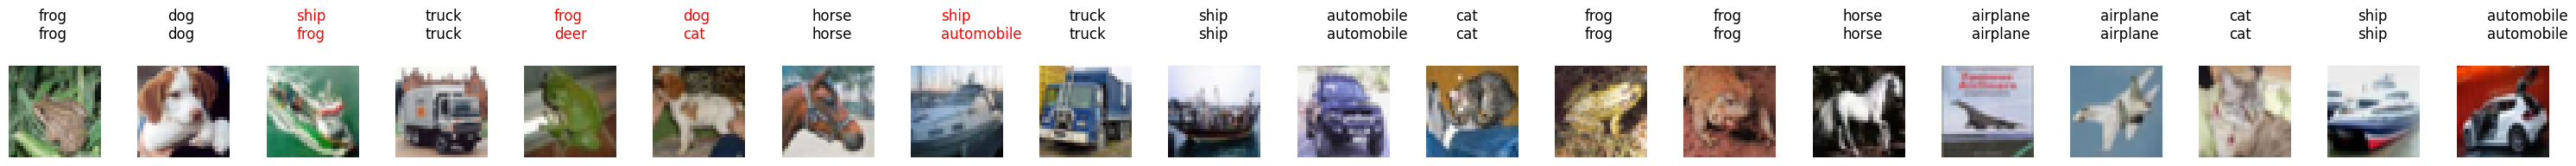

In [60]:
import json
import torch

truncated_size = 20
truncated_testset = torch.utils.data.Subset(testset, range(truncated_size))
testloader = torch.utils.data.DataLoader(
    truncated_testset,
    batch_size=64,
    shuffle=True
)
images, labels = next(iter(testloader))
input_data = json.dumps({
    "data": images.tolist()
})
input_data = bytes(input_data, encoding="utf8")
result = service.run(input_data=input_data)

plt.figure(figsize=(30, 15))
for i in range(truncated_size):
    plt.subplot(1, truncated_size, i+1)
    plt.axis('off')

    font_color = 'red' if labels[i].item()!=result[i] else 'black'
    plt.text(
        x=10,
        y=-10,
        s=f"{testset.classes[labels[i].item()]}\n{testset.classes[result[i]]}",
        fontsize=12,
        color=font_color
    )
    plt.imshow(images[i].permute(1, 2, 0).reshape(32, 32, 3))
plt.tight_layout()
plt.show()

In [61]:
service.delete()

Running
2025-02-04 12:10:00+01:00 Check and wait for operation (9e756cfa-35af-4670-8bfb-8821de12a9c3) to finish.
2025-02-04 12:10:03+01:00 Deleting service entity.
Succeeded
